<a href="https://colab.research.google.com/github/MJMortensonWarwick/AI-DL/blob/main/4_1_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE)
This tutorial will walk through a vision VAE. Note VAE can be applied equally to NLP or other tasks, but vision should be a bit clearer (pun intended) right now in the module. Given it is a vision task (and we have finite data!) we will be using convolution and deconvolution (convolution transpose) layers. Let's start with the necessary imports:

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape

Let's start by building our encoder. As we need to be able to sample directly from the end of the encoder (the bottleneck) we will first define a sampling class:

In [28]:
class Sampler(Layer):
    """ 
    Samples from the latent space.
    """

    def call(self, inputs):
        # takes the mean of the latent amd the log of its variance
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # create a normal distribution for epsilon to do the reparametrisation trick
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

We can now build our encoder. Note, because we need multiple things (which are built as layers) to happen at the end of the network we cannot use the usual _Sequential()_ function:

In [29]:
latent_dim = 2 # NUMBER OF LATENT SUBSPACES

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampler()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

Next we can build the decoder. Basically this is the main network in reverse. This means we need deconvolution instead of convolution and we start with the latent space:

In [30]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

We can now add our separate models together into a single model. You'll note we need to build a lot of the stuff ourselves such as the loss function and the backpropogation. The code may be a little complex but it is just the same things we looked at previously just we need to build them ourselves rather than letting Keras take care of it:


In [31]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        ''' OOP code to initiate an objecti of this type.
        Takes the encoder & decoder as input and metrics as kwargs
        '''
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_losses = keras.metrics.Mean(name="total_loss")
        self.reconstruction_losses = keras.metrics.Mean(
                                            name="reconstruction_loss")
        self.kl_losses = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        '''
        Returns the losses at a given stage
        '''
        return [
            self.total_losses,
            self.reconstruction_losses,
            self.kl_losses]

    def train_step(self, data):
        '''
        Training steps - i.e. backpropogation
        '''
        with tf.GradientTape() as tape:
            # get parameters for the encoded space
            z_mean, z_log_var, z = self.encoder(data)
            # reconstruct the image via decoding
            reconstruction = self.decoder(z)
            # calculate reconstruction loss as real minus reconstruction
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            # formula from earlier slides
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        # calculate and apply gradients against total loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # update the various losses
        self.total_losses.update_state(total_loss)
        self.reconstruction_losses.update_state(reconstruction_loss)
        self.kl_losses.update_state(kl_loss)
        return {
            "loss": self.total_losses.result(),
            "reconstruction_loss": self.reconstruction_losses.result(),
            "kl_loss": self.kl_losses.result(),
        }


Basically this is all the stuff from Monday that you didn't enjoy. Moving swiftly on let's do some training:

In [32]:
from keras.datasets import mnist

# y values are not relevant
(X_train, X_test), (Y_train, Y_test) = mnist.load_data()
X_train = np.expand_dims(X_train, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_train,  epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 10s 19ms/step - loss: 255.5187 - reconstruction_loss: 206.7897 - kl_loss: 2.6853
Epoch 2/30
469/469 [==============================] - 9s 18ms/step - loss: 173.3408 - reconstruction_loss: 165.4931 - kl_loss: 4.6639
Epoch 3/30
469/469 [==============================] - 9s 18ms/step - loss: 164.4767 - reconstruction_loss: 158.4153 - kl_loss: 5.0883
Epoch 4/30
469/469 [==============================] - 9s 18ms/step - loss: 161.0989 - reconstruction_loss: 155.2530 - kl_loss: 5.3021
Epoch 5/30
469/469 [==============================] - 9s 18ms/step - loss: 159.1292 - reconstruction_loss: 153.2168 - kl_loss: 5.4460
Epoch 6/30
469/469 [==============================] - 9s 19ms/step - loss: 157.6543 - reconstruction_loss: 151.8349 - kl_loss: 5.5466
Epoch 7/30
469/469 [==============================] - 9s 18ms/step - loss: 156.6605 - reconstruction_loss: 150.6998 - kl_loss: 5.6177
Epoch 8/30
469/469 [==============================] - 9s 18ms

All fit! Lastly I have a really horrible function copied from the Keras docs to make a pretty picture of the stuff in the latent space. Enjoy!

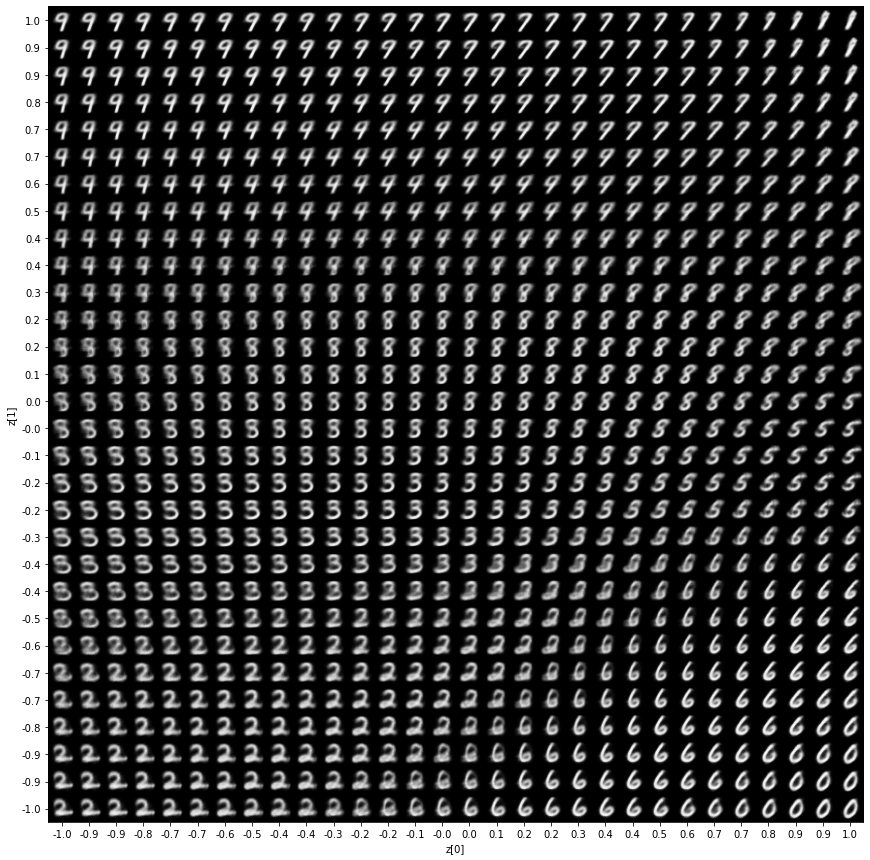

In [34]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)